# BGS MODELS

In [19]:
library(GenomicRanges)
library(tidyverse)
library(cowplot)
library(Rcpp)
library(purrr)
library(tidyr)
theme_set(cowplot::theme_cowplot())
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

#Calculates G
cppFunction(
  'NumericVector get_G(double U, double sh, double P, NumericVector fd_i, NumericVector M_1, NumericVector M_2) {

  int n = M_1.size();
  double G_k;
  double M_i;
  NumericVector G_i(n);

  for(int i = 0; i < n; ++i) {
    M_i =  (M_1[i] + M_2[i]) / 2;
    for(int k = 0; k < n; ++k){
      G_k = U * fd_i[k] * sh / (2 * (sh + P*std::abs(M_i - M_1[k]))*(sh + P*std::abs(M_i - M_2[k])));
      G_i[i] += G_k;
    }
  }
  return G_i;
}'
)


#deterministic model components
theta_full <- function(theta, G_i, alpha, fd_i, rbp_i){
  theta / (1/exp(-G_i) + alpha * fd_i / rbp_i)
}

theta_noBGS <- function(theta, G_i, alpha, fd_i, rbp_i){
  theta / (1 + alpha * fd_i / rbp_i)
} 

theta_noHH <- function(theta, G_i, alpha, fd_i, rbp_i){
  theta / (1/exp(-G_i))
} 

theta_intercept <- function(theta, G_i, alpha, fd_i, rbp_i){
  theta
}

#log likelihood equations to optimize
LL_full <- function(pi_obs, par, G_i, fd_i, rbp_i, mode = "beta"){
  
  #rescaled parameters to make optimization easier
  theta <- 1/exp(par[1])
  alpha <- 1/exp(par[2])
  sigma <- 1/exp(par[3])
  
  pi_pred <- theta_full(theta, G_i, alpha, fd_i, rbp_i)
  #print(str_glue("theta:{theta} alpha:{alpha} sigma:{sigma}"))
    
  if(mode == "beta"){ 
    -sum(dbeta(x = pi_obs, shape1 = pi_pred * sigma, shape2 = (1 - pi_pred) * sigma, log = TRUE))  
  } else {
    -sum(dnorm(x = pi_obs, mean = pi_pred, sd = sigma, log = TRUE))
  }
  
}

LL_noBGS <- function(pi_obs, par, G_i, fd_i, rbp_i, mode = "beta"){
  
  #rescaled parameters to make optimization easier
  theta <- 1/exp(par[1])
  alpha <- 1/exp(par[2])
  sigma <- 1/exp(par[3])
  
  pi_pred <- theta_noBGS(theta, G_i, alpha, fd_i, rbp_i)  
  
  if(mode == "beta"){
    -sum(dbeta(x = pi_obs, shape1 = pi_pred * sigma, shape2 = (1 - pi_pred) * sigma, log = TRUE))  
  } else {
    -sum(dnorm(x = pi_obs, mean = pi_pred, sd = sigma, log = TRUE))
  }
}



LL_noHH <- function(pi_obs, par, G_i, fd_i, rbp_i, mode = "beta"){
  
  #rescaled parameters to make optimization easier
  theta <- 1/exp(par[1])
  sigma <- 1/exp(par[2])
  
  pi_pred <- theta_noHH(theta, G_i, alpha, fd_i, rbp_i)
  
  if(mode == "beta"){
    -sum(dbeta(x = pi_obs, shape1 = pi_pred * sigma, shape2 = (1 - pi_pred) * sigma, log = TRUE))  
  } else {
    -sum(dnorm(x = pi_obs, mean = pi_pred, sd = sigma, log = TRUE))
  }
}


LL_intercept <- function(pi_obs, par, G_i, fd_i, rbp_i, mode = "beta"){
  
  #rescaled parameters to make optimization easier
  theta <- 1/exp(par[1])
  sigma <- 1/exp(par[2])
  
  pi_pred <- theta_intercept(theta, G_i, alpha, fd_i, rbp_i)
  
  if(mode == "beta"){
    -sum(dbeta(x = pi_obs, shape1 = pi_pred * sigma, shape2 = (1 - pi_pred) * sigma, log = TRUE))  
  } else {
    -sum(dnorm(x = pi_obs, mean = pi_pred, sd = sigma, log = TRUE))
  }
}


#get confidence intervals of parameters
get_conf <- function(model, param = c("theta", "alpha", "sigma")){
  
  se <- sqrt(diag(solve(model$hessian)))
  lows <- 1/exp(model$par+1.96*se)
  highs <- 1/exp(model$par-1.96*se)
  expected <- 1/exp(model$par)
  conf_df <- data.frame(
    param = param, 
    lower=lows, 
    value=expected, 
    upper=highs)
  conf_df
}

#prediction intervals based on uncertainty predicted from model
predict_df <- function(model, new_data, E_theta, param = c("theta", "alpha", "sigma"), levels = c(0.025, 0.975), mode = "beta"){
  
  conf_df <- get_conf(model, param = param)
  theta_df <- filter(conf_df, param == "theta")
  alpha_df <- filter(conf_df, param == "alpha")
  sig_df <- filter(conf_df, param == "sigma")
  sigma_low <- sig_df$lower
  sigma_upper <- sig_df$upper
  
  e_exp <- E_theta(theta = theta_df$value[1], 
                   G_i = new_data$G_i, 
                   alpha = alpha_df$value[1], 
                   fd_i = new_data$fd_i, 
                   rbp_i = new_data$rbp_i)
  
  
  if(mode == "beta"){
    pred_df <- 
      e_exp %>%
      map_df(~{
        tibble(
          expected_pi = .x,
          low = quantile(rbeta(100, shape1 = .x*sigma_low, shape2 = (1 - .x) * sigma_low), probs = levels[1]),
          high = quantile(rbeta(100, shape1 = .x*sigma_upper, shape2 = ( 1-.x) * sigma_upper), probs = levels[2])
        )
      })    
  } else {
    pred_df <- 
      e_exp %>%
      map_df(~{
        tibble(
          expected_pi = .x,
          low = quantile(rnorm(100, .x, sigma_low), probs = levels[1]),
          high = quantile(rnorm(100, .x, sigma_upper), probs = levels[2])
        )
      })
  }
  
  bind_cols(new_data, pred_df)
}



AIC_all <- function(mod_full, mod_noBGS, mod_noHH, mod_intercept){
  
  #get model AIC
  AIC <- function(model, K){
    2*K + 2*model$value
  }
  
  model <- c("full", "noBGS", "noHH", "intercept")
  
  nlls <- c("mod_full" = mod_full$value,
            "mod_noBGS" = mod_noBGS$value,
            "mod_noHH" = mod_noHH$value,
            "mod_intercept" = mod_intercept$value)
  
  
  AICs <- c("mod_full" = AIC(mod_full, 3),
            "mod_noBGS" = AIC(mod_noBGS, 3),
            "mod_noHH" = AIC(mod_noHH, 2),
            "mod_intercept" = AIC(mod_intercept, 2))
  
  AIC_delta <- AICs - min(AICs) 
  AIC_weight <- exp(-0.5 * AIC_delta )/sum(exp(-0.5 * AIC_delta ))
  tibble(model, nLL = nlls, AIC = AICs, AIC_delta, AIC_weight)
}


infer_theta <- function(pi, G_i, fd_i, rbp_i, sample_size = 100, pop = "", mode = "beta", conf = TRUE, pred = TRUE){
  
  sig_bound <- c(-Inf, Inf)  
  ll <- 1e-10
  hh <- 100
  denom <- 5
  #model fit
  mod_full <- 
    optim( 
      #par = c(2,2,-2),      
      #par = rexp(n = 3, 1/2),
      par = c(1,1,-1)*rexp(3, 1/denom),
      fn = LL_full, #log likelihood function to be optimized
      pi_obs = pi, G_i = G_i, fd_i = fd_i, rbp_i = rbp_i, #non-optimized parameters passed to LL
      hessian = TRUE, 
      mode = mode,
      lower = c(ll,ll, sig_bound[1]),
      upper = c(hh, hh, sig_bound[2]),         
      method = "L-BFGS-B",   
    )
  
  mod_noBGS <- 
    optim(  
      #par = c(2, 2, 2), #initial values of theta, alpha, and sigma
      #par = c(2,2,-2),
      #par = rexp(n = 3, 1/2),
      par = c(1,1,-1)*rexp(3, 1/denom),  
      #par = ifelse(mode == "beta", c(rexp(1, 1/2), rexp(1, 1/2), -rexp(1, 1/10)), rexp(n = 3, 10)),
      fn = LL_noBGS, #log likelihood function to be optimized
      pi_obs = pi, G_i = G_i, fd_i = fd_i, rbp_i = rbp_i, #non-optimized parameters passed to LL
      hessian = TRUE,
      mode = mode,
      lower = c(ll,ll, sig_bound[1]),
      upper = c(hh, hh, sig_bound[2]), 
      method = "L-BFGS-B",
    )
  
  mod_noHH <- 
    optim(  
      #par = c(2,-2),
      #par = rexp(n = 2, 1/2),
      par = c(1,-1)*rexp(2, 1/denom),
      fn = LL_noHH,
      pi_obs = pi, G_i = G_i, fd_i = fd_i, rbp_i = rbp_i, #non-optimized parameters passed to LL
      hessian = TRUE,
      mode = mode,
      lower = c(ll, sig_bound[1]),
      upper = c(hh, sig_bound[2]), 
      method = "L-BFGS-B",
    )
  
  mod_intercept <- 
    optim(  
      #par = c(2,-2),
      #par = rexp(n = 2, 1/2),
      par = c(1,-1)*rexp(2, 1/denom),  
      fn = LL_intercept,
      pi_obs = pi, G_i = G_i, fd_i = fd_i, rbp_i = rbp_i, #non-optimized parameters passed to LL
      hessian = TRUE,
      mode = mode,
      lower = c(ll, sig_bound[1]),        
      upper = c(hh, sig_bound[2]), 
      method = "L-BFGS-B",
    )
  

  aic_df <- AIC_all(mod_full, mod_noBGS, mod_noHH, mod_intercept) %>% 
    mutate(pop = pop, mode = mode)
  
  
  if(conf){
    conf_df <- 
      bind_rows(
        get_conf(mod_full, c("theta", "alpha","sigma")) %>% mutate(model = "full"),
        get_conf(mod_noBGS, c("theta", "alpha","sigma")) %>% mutate(model = "noBGS"),
        get_conf(mod_noHH, c("theta", "sigma")) %>% mutate(model = "noHH"),
        get_conf(mod_intercept, c("theta", "sigma")) %>% mutate(model = "intercept")
      ) %>% 
      mutate(pop = pop, mode = mode)
  } else{conf_df <- tibble()}
  
  #make a data frame of the variables and randomly sample 1000 rows for input
  new_df <- 
    tibble(
      pi = pi,
      G_i = G_i,
      fd_i = fd_i,
      rbp_i = rbp_i 
    ) %>% 
    sample_n(sample_size)
  
    
  if(pred){
  pred_df <- 
    bind_rows(
      predict_df(mod_full, new_data = new_df, param = c("theta","alpha","sigma"), E_theta = theta_full, mode = mode) %>% 
        mutate(model = "full", mode = mode),
      predict_df(mod_intercept, new_data = new_df, param = c("theta","sigma"), E_theta = theta_intercept, mode = mode) %>% 
        mutate(model = "intercept", mode = mode),
      predict_df(mod_noHH, new_data = new_df, param = c("theta","sigma"), E_theta = theta_noHH) %>% 
        mutate(model = "noHH", mode = mode),
      predict_df(mod_noBGS, new_data = new_df, param = c("theta","alpha","sigma"), E_theta = theta_noBGS, mode = mode) %>% 
        mutate(model = "noBGS", mode = mode)
    ) %>% 
    mutate(pop = pop)      
  } else {
    pred_df  <- tibble()
  }  
  
  theta_list <- list(pred_df = pred_df, conf_df = conf_df, aic_df = aic_df)
  return(theta_list)
}


#!!!REQUIRES ALL INPUT DFS INCLUDE COLUMN NAMES chr, start, end
CM <- function(genetic_df, pi_df){
  tibble(
  cm_start = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$start)$y,
  cm_end = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$end)$y,
  cm_mid = (cm_start + cm_end)/2,
  cm_mb = approx(x = genetic_df$pos, y = genetic_df$cm_mb, xout = (pi_df$start + pi_df$end)/2)$y,
  rec = cm_end - cm_start
  )
}

#Reading in our PI Data
read_angsd_pi = function(pi_file, minimum_sites = 0.01){
  vroom::vroom(
    pi_file, skip = 1,
    col_names = c("info", "chr", "WinCenter", "tW","tP","tF","tH","tL","Tajima","fuf","fud","fayh","zeng","nSites")) %>%
    separate(info, sep = "[\\)\\(,]", into = c(letters[1:7], "WinStart", "WinStop", "g2")) %>% 
    dplyr::select(-c(letters[1:7], g2)) %>%
    mutate(start = as.numeric(WinStart), 
           end = as.numeric(WinStop),
           size = end - start) %>% 
    na.omit() %>% 
    mutate(pi = tP / nSites) %>% 
    filter(pi > 0, nSites > minimum_sites*size) %>%
    dplyr::select(chr, start, end, pi)        
}



build_bgs_fit <- function(chrms, pi_df, genetic_map_df, functional_df, s, h, mu, pop, conf = F, pred = F, mode = "beta"){
    
    Total_Exonic_Sites <- sum(functional_df$end - functional_df$start)
    
    #iterate over chromosomes
    model_df <- chrms %>%  
      map_df(~{
      
      #filter data sets for current chromosome    
      gen_map_chr <- filter(genetic_map_df, chr == .x)
      pi_df_chr <- filter(pi_df, chr == .x)
      morgan_df <- CM(genetic_df = gen_map_chr, pi_df = pi_df_chr)
      gff_chr <- filter(functional_df, chr == .x)
      
      #get number of functional bases in each pi window using GenomicRanges
      pi_idx <- tibble(queryHits = seq_len(nrow(pi_df_chr)), widths = 0)
      gr1 <- GRanges(pi_df_chr$chr, IRanges(pi_df_chr$start, pi_df_chr$end))
      gr2 <- GRanges(gff_chr$chr, IRanges(gff_chr$start, gff_chr$end))
      hits <- findOverlaps(gr1, gr2)
      overlaps <- pintersect(gr1[queryHits(hits)], gr2[subjectHits(hits)])
      functional_bps_raw <- 
      data.frame(findOverlaps(gr1, gr2)) %>% 
      mutate(widths = width(overlaps)) %>% 
      full_join(., pi_idx, by = c("queryHits", "widths")) %>% 
      group_by(queryHits) %>%
      summarise(widths = sum(widths), .groups = 'drop') %>% 
      pull(widths)
      functional_bps <- functional_bps_raw/Total_Exonic_Sites  
      
      #Collect all the features    
      g_df  <- bind_cols(tibble(functional_bps_raw = functional_bps_raw, functional_bps = functional_bps), morgan_df, pi_df_chr) %>% drop_na()
      G <- get_G(U = mu * Total_Exonic_Sites, sh = s * h, P = 1, fd_i = g_df$functional_bps,  M_1 = g_df$cm_start/100,  M_2 = g_df$cm_end/100)
      Beta = exp(-(mu*g_df$functional_bps_raw)/(g_df$cm_mb/1e4))                            
      rho = (1-exp(-1*(g_df$cm_mb/1e6)*2/100))/2
                                    
      mutate(g_df, G = G, Beta = Beta, rho = rho)
                                    
                                    
      #G <- get_G(U = mu * Total_Exonic_Sites, sh = s * h, P = 1, fd_i = functional_bps,  M_1 = morgan_df$cm_start/100,  M_2 = morgan_df$cm_end/100)
      #Beta = exp(-(mu*functional_bps_raw)/(morgan_df$cm_mb/1e4))
      #rho = (1-exp(-1*(morgan_df$cm_mb/1e6)*2/100))/2
      #tibble(pi, G, functional_bps, rho, Beta, chr = .x, start = pi_df_chr$start, end = pi_df_chr$end)
                                    
    }) %>% 
      drop_na()

    #fit the 
    mod_fits <- infer_theta(
        model_df$pi, 
        model_df$G, 
        model_df$functional_bps,
        model_df$rho, 
        sample_size = min(nrow(model_df), 1000), 
        pop = pop, 
        conf = conf, 
        pred = pred, 
        mode = mode)
    
        list(
        conf_df = mod_fits$conf_df %>% mutate(s = s, mu = mu, h = h, pop = pop),
        pred_df = mod_fits$pred_df %>% mutate(s = s, mu = mu, h = h, pop = pop),
        aic_df = mod_fits$aic_df %>% mutate(s = s, mu = mu, h = h, pop = pop)
        )
    
}

In [20]:
pi_files <- list.files(path = "../data/angsd_pi", pattern = "(1000000|100000)BP_theta.txt", full.names = TRUE)
pops <- str_replace(pi_files, "../data/angsd_pi/(..*)_theta.txt", "\\1")

#file_df <- separate(tibble(file = pi_files, x = pi_files), x, sep = "--|\\.", into = c("a", "b", "path", "ssp", "pop", "chrom", "start", "end", "bp", "j", "k", "l")) %>% 
#mutate(ssp_pop = str_glue("{ssp}_{pop}"),
#      ssp_pop_bp = str_glue("{ssp}_{pop}_{bp}"))

gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    bind_cols(df2, cm_mb)
  }) %>% 
  mutate(chr = paste0("chr", chr))


#made with 
#zcat < data/refs/v5/v5.gff3.gz | grep "P001" | bedtools sort -i stdin | bedtools merge -i stdin > data/refs/v5_functional.bed
gff_test <- vroom::vroom(
  "../data/refs/v5_functional.bed", 
  delim = "\t",
  comment = "#", 
  col_names = c("chr", "start", "end")
  )

chrms <- paste0("chr", 1:10)

head(gff_test); head(gen_map_all_chr)

pi_files


quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.5) / quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.75) 
quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.5) / quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.25)
quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.95) / quantile(gen_map_all_chr$cm_mb / (1e6*100), 0.5) 


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_double(),
  pos = col_double(),
  cm = col_double()
)


Rows: 164,426
Columns: 3
Delimiter: "\t"
chr [1]: chr
dbl [2]: start, end

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



chr,start,end
<chr>,<dbl>,<dbl>
chr1,34616,35318
chr1,36036,36174
chr1,36258,36504
chr1,36599,36713
chr1,36821,37004
chr1,37415,37633


chr,pos,cm,cm_mb
<chr>,<dbl>,<dbl>,<dbl>
chr1,214369,3.4,2.246181
chr1,341276,3.6,1.575957
chr1,370511,3.8,6.841115
chr1,532547,4.2,2.468587
chr1,603370,4.4,2.823941
chr1,694670,4.6,2.190581


[1] "../data/angsd_pi/v5--LR--Amatlan_de_Canas.1000000BP_theta.txt"     
 [2] "../data/angsd_pi/v5--LR--Amatlan_de_Canas.100000BP_theta.txt"      
 [3] "../data/angsd_pi/v5--LR--Crucero_Lagunitas.1000000BP_theta.txt"    
 [4] "../data/angsd_pi/v5--LR--Crucero_Lagunitas.100000BP_theta.txt"     
 [5] "../data/angsd_pi/v5--LR--Los_Guajes.1000000BP_theta.txt"           
 [6] "../data/angsd_pi/v5--LR--Los_Guajes.100000BP_theta.txt"            
 [7] "../data/angsd_pi/v5--LR--Palmar_Chico.1000000BP_theta.txt"         
 [8] "../data/angsd_pi/v5--LR--Palmar_Chico.100000BP_theta.txt"          
 [9] "../data/angsd_pi/v5--LR--random.1000000BP_theta.txt"               
[10] "../data/angsd_pi/v5--LR--random.100000BP_theta.txt"                
[11] "../data/angsd_pi/v5--LR--random1_Palmar_Chico.1000000BP_theta.txt" 
[12] "../data/angsd_pi/v5--LR--random1_Palmar_Chico.100000BP_theta.txt"  
[13] "../data/angsd_pi/v5--LR--random2_Palmar_Chico.1000000BP_theta.txt" 
[14] "../data/angsd_pi/v5--LR--random2_Palmar_Chico.100000BP_theta.txt"  
[15] "../data/angsd_pi/v5--LR--San_Lorenzo.1000000BP_theta.txt"          
[16] "../data/angsd_pi/v5--LR--San_Lorenzo.100000BP_theta.txt"           
[17] "../data/angsd_pi/v5--Teo--Amatlan_de_Canas.1000000BP_theta.txt"    
[18] "../data/angsd_pi/v5--Teo--Amatlan_de_Canas.100000BP_theta.txt"     
[19] "../data/angsd_pi/v5--Teo--Crucero_Lagunitas.1000000BP_theta.txt"   
[20] "../data/angsd_pi/v5--Teo--Crucero_Lagunitas.100000BP_theta.txt"    
[21] "../data/angsd_pi/v5--Teo--El_Rodeo.1000000BP_theta.txt"            
[22] "../data/angsd_pi/v5--Teo--El_Rodeo.100000BP_theta.txt"             
[23] "../data/angsd_pi/v5--Teo--Los_Guajes.1000000BP_theta.txt"          
[24] "../data/angsd_pi/v5--Teo--Los_Guajes.100000BP_theta.txt"           
[25] "../data/angsd_pi/v5--Teo--Palmar_Chico.1000000BP_theta.txt"        
[26] "../data/angsd_pi/v5--Teo--Palmar_Chico.100000BP_theta.txt"         
[27] "../data/angsd_pi/v5--Teo--random.1000000BP_theta.txt"              
[28] "../data/angsd_pi/v5--Teo--random.100000BP_theta.txt"               
[29] "../data/angsd_pi/v5--Teo--random1_Palmar_Chico.1000000BP_theta.txt"
[30] "../data/angsd_pi/v5--Teo--random1_Palmar_Chico.100000BP_theta.txt" 
[31] "../data/angsd_pi/v5--Teo--random2_Palmar_Chico.1000000BP_theta.txt"
[32] "../data/angsd_pi/v5--Teo--random2_Palmar_Chico.100000BP_theta.txt" 
[33] "../data/angsd_pi/v5--Teo--San_Lorenzo.1000000BP_theta.txt"         
[34] "../data/angsd_pi/v5--Teo--San_Lorenzo.100000BP_theta.txt"

50% 
0.5023346

50% 
2.031905

95% 
3.648353

In [ ]:
param_grid <- expand_grid(s = 10^seq(-8, -1, length.out = 30), mu = c(1e-7, 3e-8), h = c(.5))
full_fits <- 
pops %>% map(~{
    print(.x)
    PI <- read_angsd_pi(str_glue("../data/angsd_pi/{.x}_theta.txt"))
    pmap(param_grid, function(s, mu, h, pop = .x){
        model_df <- build_bgs_fit(
            chrms = chrms, 
            pi_df= PI, 
            genetic_map_df = gen_map_all_chr, 
            functional_df = gff_test, 
            s = s, h = h, mu = mu, pop = .x, mode = "beta", conf = FALSE)
        })    
    })

#commented out to avoid overwriting
saveRDS(full_fits, "bgs_fullfit.rds")

[1] "v5--LR--Amatlan_de_Canas.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Amatlan_de_Canas.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Crucero_Lagunitas.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Crucero_Lagunitas.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Los_Guajes.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Los_Guajes.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random1_Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random1_Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random2_Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--random2_Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--San_Lorenzo.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--LR--San_Lorenzo.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Amatlan_de_Canas.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Amatlan_de_Canas.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Crucero_Lagunitas.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Crucero_Lagunitas.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--El_Rodeo.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--El_Rodeo.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Los_Guajes.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Los_Guajes.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random1_Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random1_Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random2_Palmar_Chico.1000000BP"


Rows: 2,118
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] "v5--Teo--random2_Palmar_Chico.100000BP"


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



In [22]:
#HERE
full_fits <- readRDS("bgs_fullfit.rds")

aic_df <- map_df(full_fits, ~ map_df(.x, function(x) x$aic_df))

best_mod_8 <- aic_df %>% 
    group_by(pop) %>%
    filter(grepl(pattern = "100000BP", pop), mu == 3e-8) %>% 
    mutate(AIC_delta = AIC - min(AIC), 
           AIC_weight = exp(-0.5 * AIC_delta )/sum(exp(-0.5 * AIC_delta ))) %>% 
           arrange(AIC_delta) %>% slice(1)

best_mod_7 <- aic_df %>% 
    group_by(pop) %>%
    filter(grepl(pattern = "100000BP", pop), mu == 1e-7) %>% 
    mutate(AIC_delta = AIC - min(AIC), 
           AIC_weight = exp(-0.5 * AIC_delta )/sum(exp(-0.5 * AIC_delta ))) %>% 
           arrange(AIC_delta) %>% slice(1)
                                     
                                    
best_mod_8                           
best_mod_7

model,nLL,AIC,AIC_delta,AIC_weight,pop,mode,s,mu,h
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
full,-98390.53,-196775.1,0,1.0000000,v5--LR--Amatlan_de_Canas.100000BP,beta,5.736153e-02,3e-08,0.5
full,-97546.25,-195086.5,0,1.0000000,v5--LR--Crucero_Lagunitas.100000BP,beta,5.736153e-02,3e-08,0.5
full,-98526.16,-197046.3,0,1.0000000,v5--LR--Los_Guajes.100000BP,beta,5.736153e-02,3e-08,0.5
full,-96272.03,-192538.1,0,0.9661916,v5--LR--Palmar_Chico.100000BP,beta,3.290345e-02,3e-08,0.5
full,-97556.24,-195106.5,0,0.9999987,v5--LR--random.100000BP,beta,5.736153e-02,3e-08,0.5
full,-98327.88,-196649.8,0,0.7830215,v5--LR--random1_Palmar_Chico.100000BP,beta,3.290345e-02,3e-08,0.5
full,-98461.35,-196916.7,0,0.9506969,v5--LR--random2_Palmar_Chico.100000BP,beta,5.736153e-02,3e-08,0.5
full,-97961.50,-195917.0,0,1.0000000,v5--LR--San_Lorenzo.100000BP,beta,5.736153e-02,3e-08,0.5
full,-98400.20,-196794.4,0,0.6490966,v5--Teo--Amatlan_de_Canas.100000BP,beta,1.610262e-07,3e-08,0.5


model,nLL,AIC,AIC_delta,AIC_weight,pop,mode,s,mu,h
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
full,-97948.72,-195891.4,0,0.9943091,v5--LR--Amatlan_de_Canas.100000BP,beta,9.236709e-08,1e-07,0.5
full,-97337.77,-194669.5,0,0.9992646,v5--LR--Crucero_Lagunitas.100000BP,beta,9.236709e-08,1e-07,0.5
full,-98079.69,-196153.4,0,0.8938606,v5--LR--Los_Guajes.100000BP,beta,9.236709e-08,1e-07,0.5
full,-95684.16,-191362.3,0,1.0000000,v5--LR--Palmar_Chico.100000BP,beta,9.236709e-08,1e-07,0.5
full,-97235.11,-194464.2,0,1.0000000,v5--LR--random.100000BP,beta,9.236709e-08,1e-07,0.5
full,-97702.02,-195398.0,0,1.0000000,v5--LR--random1_Palmar_Chico.100000BP,beta,9.236709e-08,1e-07,0.5
full,-97931.16,-195856.3,0,1.0000000,v5--LR--random2_Palmar_Chico.100000BP,beta,9.236709e-08,1e-07,0.5
full,-97540.79,-195075.6,0,1.0000000,v5--LR--San_Lorenzo.100000BP,beta,9.236709e-08,1e-07,0.5
full,-98403.35,-196800.7,0,0.9999995,v5--Teo--Amatlan_de_Canas.100000BP,beta,5.298317e-08,1e-07,0.5


In [23]:
library(patchwork)
chrms <- paste0("chr", 1:10)

best_fit_list <- best_mod_8 %>% 
dplyr::select(pop, s, mu, h) %>% 
    pmap(function(pop, s, mu, h){
        PI <- read_angsd_pi(str_glue("../data/angsd_pi/{pop}_theta.txt"))
        build_bgs_fit(
            chrms = chrms,
            pi_df= PI, 
            genetic_map_df = gen_map_all_chr, 
            functional_df = gff_test, 
            s = s, h = h, mu = mu, pop = pop,
            conf = T, pred = T, mode = "beta")
        })

#commented out to avoid overwriting on accident
saveRDS(best_fit_list, "bgs_bestfit_mu-8.rds")



library(patchwork)
chrms <- paste0("chr", 1:10)

best_fit_list <- best_mod_7 %>% 
dplyr::select(pop, s, mu, h) %>% 
    pmap(function(pop, s, mu, h){
        PI <- read_angsd_pi(str_glue("../data/angsd_pi/{pop}_theta.txt"))
        build_bgs_fit(
            chrms = chrms,
            pi_df= PI, 
            genetic_map_df = gen_map_all_chr, 
            functional_df = gff_test, 
            s = s, h = h, mu = mu, pop = pop,
            conf = T, pred = T, mode = "beta")
        })

#commented out to avoid overwriting on accident
saveRDS(best_fit_list, "bgs_bestfit_mu-7.rds")


Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message in sqrt(diag(solve(model$hessian))):
“NaNs produced”
Warning message in sqrt(diag(solve(model$hessian))):
“NaNs produced”
Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: i

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specif

In [27]:
mu_int <- 8
best_fit_list <- readRDS(str_glue("bgs_bestfit_mu-{mu_int}.rds"))
best_mod <- eval(parse(text = str_glue("best_mod_{mu_int}")))

aic_df <- map_df(best_fit_list, ~ .x$aic_df)
conf_df <- map_df(best_fit_list, ~ .x$conf_df)
pred_df <- map_df(best_fit_list, ~ .x$pred_df)


Warning message:
“Removed 1 rows containing missing values (geom_segment).”


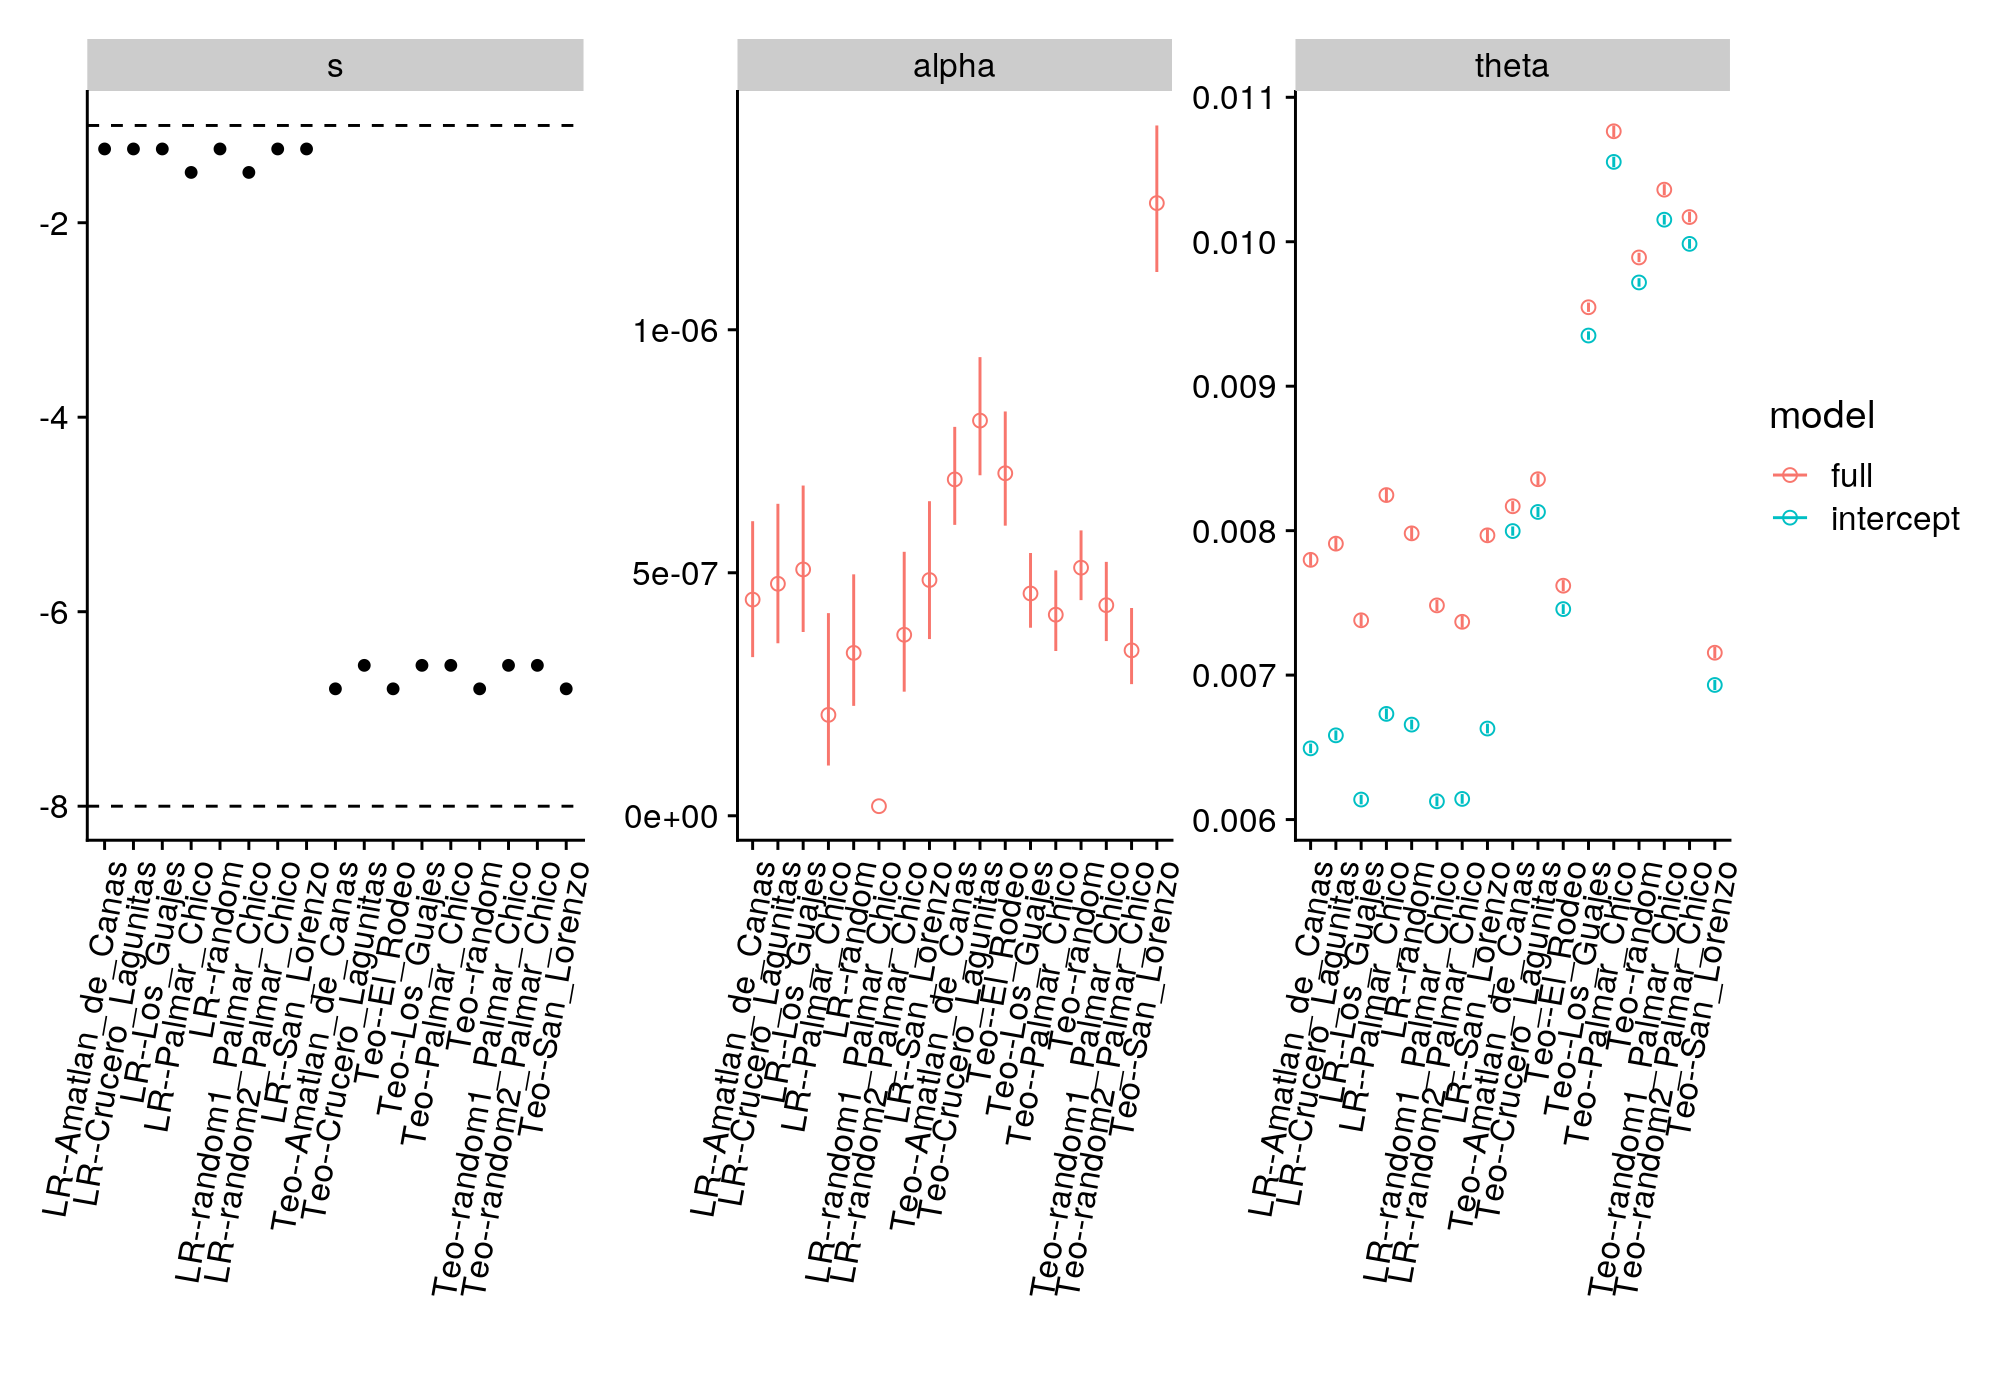

In [28]:
a  <- filter(conf_df, model %in% c("full", "intercept"), param != "sigma") %>% 
    mutate(pop = str_remove_all(pop, ".100000BP"),
          pop = str_remove_all(pop, "v5--")) %>% 
    #mutate(lower = log10(lower), value = log10(value), upper = log10(upper)) %>% 
    ggplot() +
    geom_segment(mapping = aes(x = pop, xend = pop, y = lower, yend = upper, colour = model)) +
    geom_point(mapping = aes(pop, value, colour = model), shape = 21, size = 2, inherit.aes = F) +
    facet_wrap(~param, scales = "free") +
    theme(axis.text.x=element_text(angle = 80, hjust = 1), 
          axis.title.y=element_blank()) +
    xlab("")
    

b  <- best_mod %>% 
    mutate(pop = str_remove_all(pop, ".100000BP"),
           pop = str_remove_all(pop, "v5--"),
          S = "s") %>% 
    ggplot(aes(pop, log10(s))) +
    geom_point() +
    facet_wrap(~S, scales = "free") +
    theme(axis.text.x=element_text(angle = 80, hjust = 1),
          axis.title.y=element_blank(),
          legend.position = "n") +
    ylab("") +
    xlab("") +
    geom_hline(yintercept = log10(1e-8), lty = 2) +
    geom_hline(yintercept = log10(1e-1), lty = 2)

b + a + plot_layout(widths = c(1,2))

Warning message:
“Removed 198 rows containing missing values (geom_point).”
Warning message:
“Removed 17 row(s) containing missing values (geom_path).”


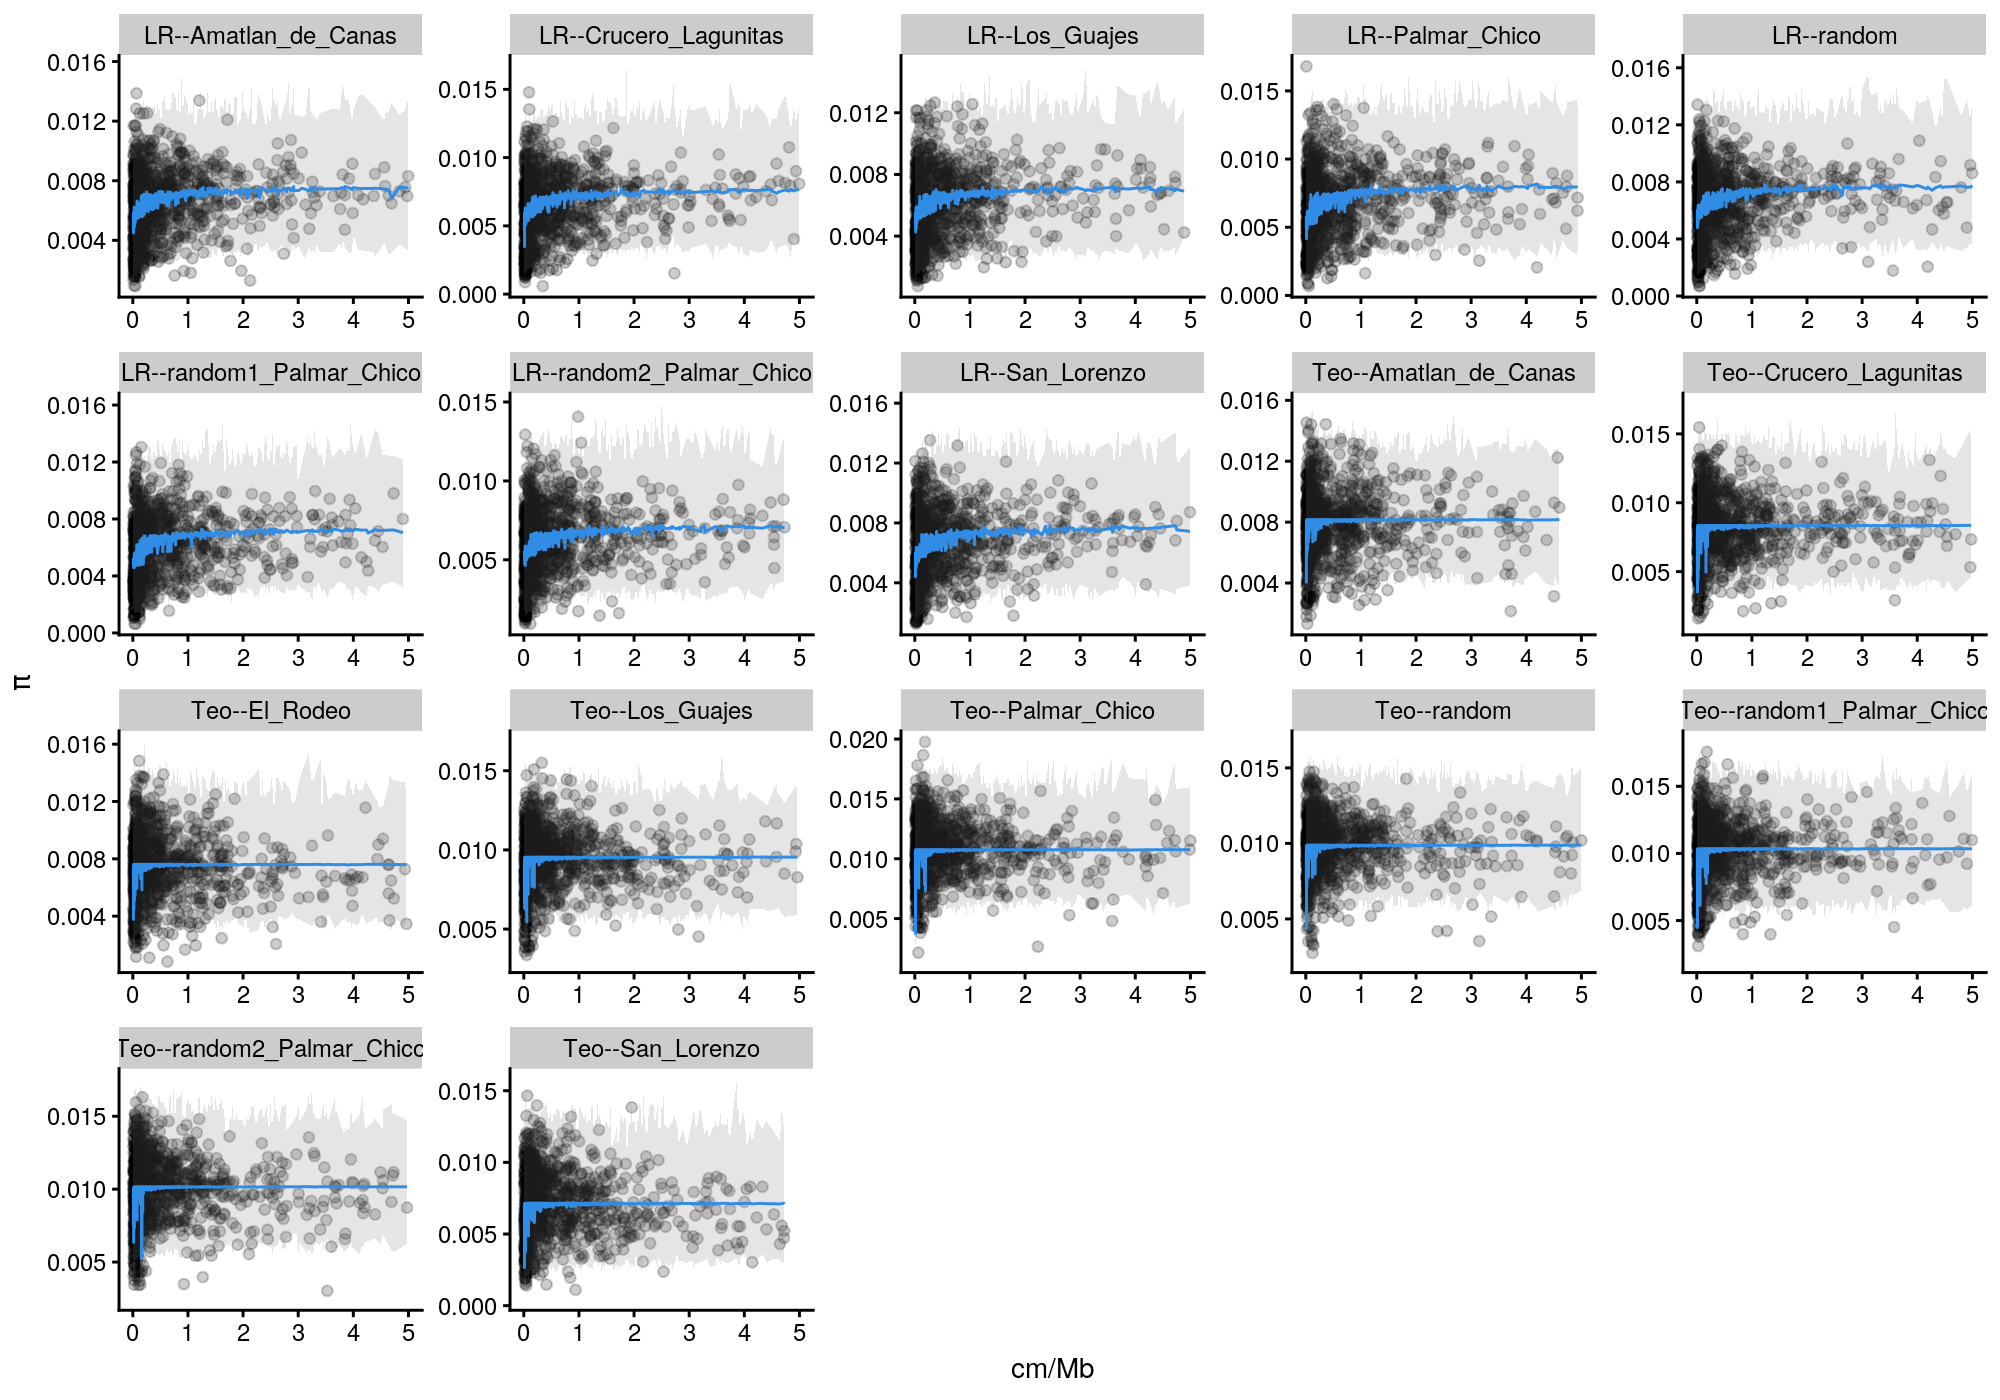

In [31]:
pred_df %>% 
    filter(model == "full") %>% 
    mutate(pop = str_remove_all(pop, ".100000BP"),
           pop = str_remove_all(pop, "v5--")) %>% 
    mutate(rbp_i = -1*(100/2)*log(1 - 2*rbp_i)*1e6) %>% 
    #mutate(rbp_i = log(rbp_i)) %>% 
    ggplot()+
    geom_point(mapping = aes(rbp_i, pi), alpha = 0.2) + 
    geom_line(mapping = aes(rbp_i, expected_pi), colour = "dodgerblue") +
    #geom_smooth(mapping = aes(rbp_i, pi), se = F, colour = "dodgerblue", type = 2) +
    geom_ribbon(mapping = aes(x = rbp_i, ymin = low, ymax =  high), fill = "grey50", alpha = 0.2) +
    facet_wrap(~pop, scales = "free") +
    xlab("cm/Mb") +
    ylab(expression(pi)) +
    xlim(0, 5) +
    cowplot::theme_cowplot(font_size = 10)
    

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`geom_smooth()` using formula 'y ~ x'



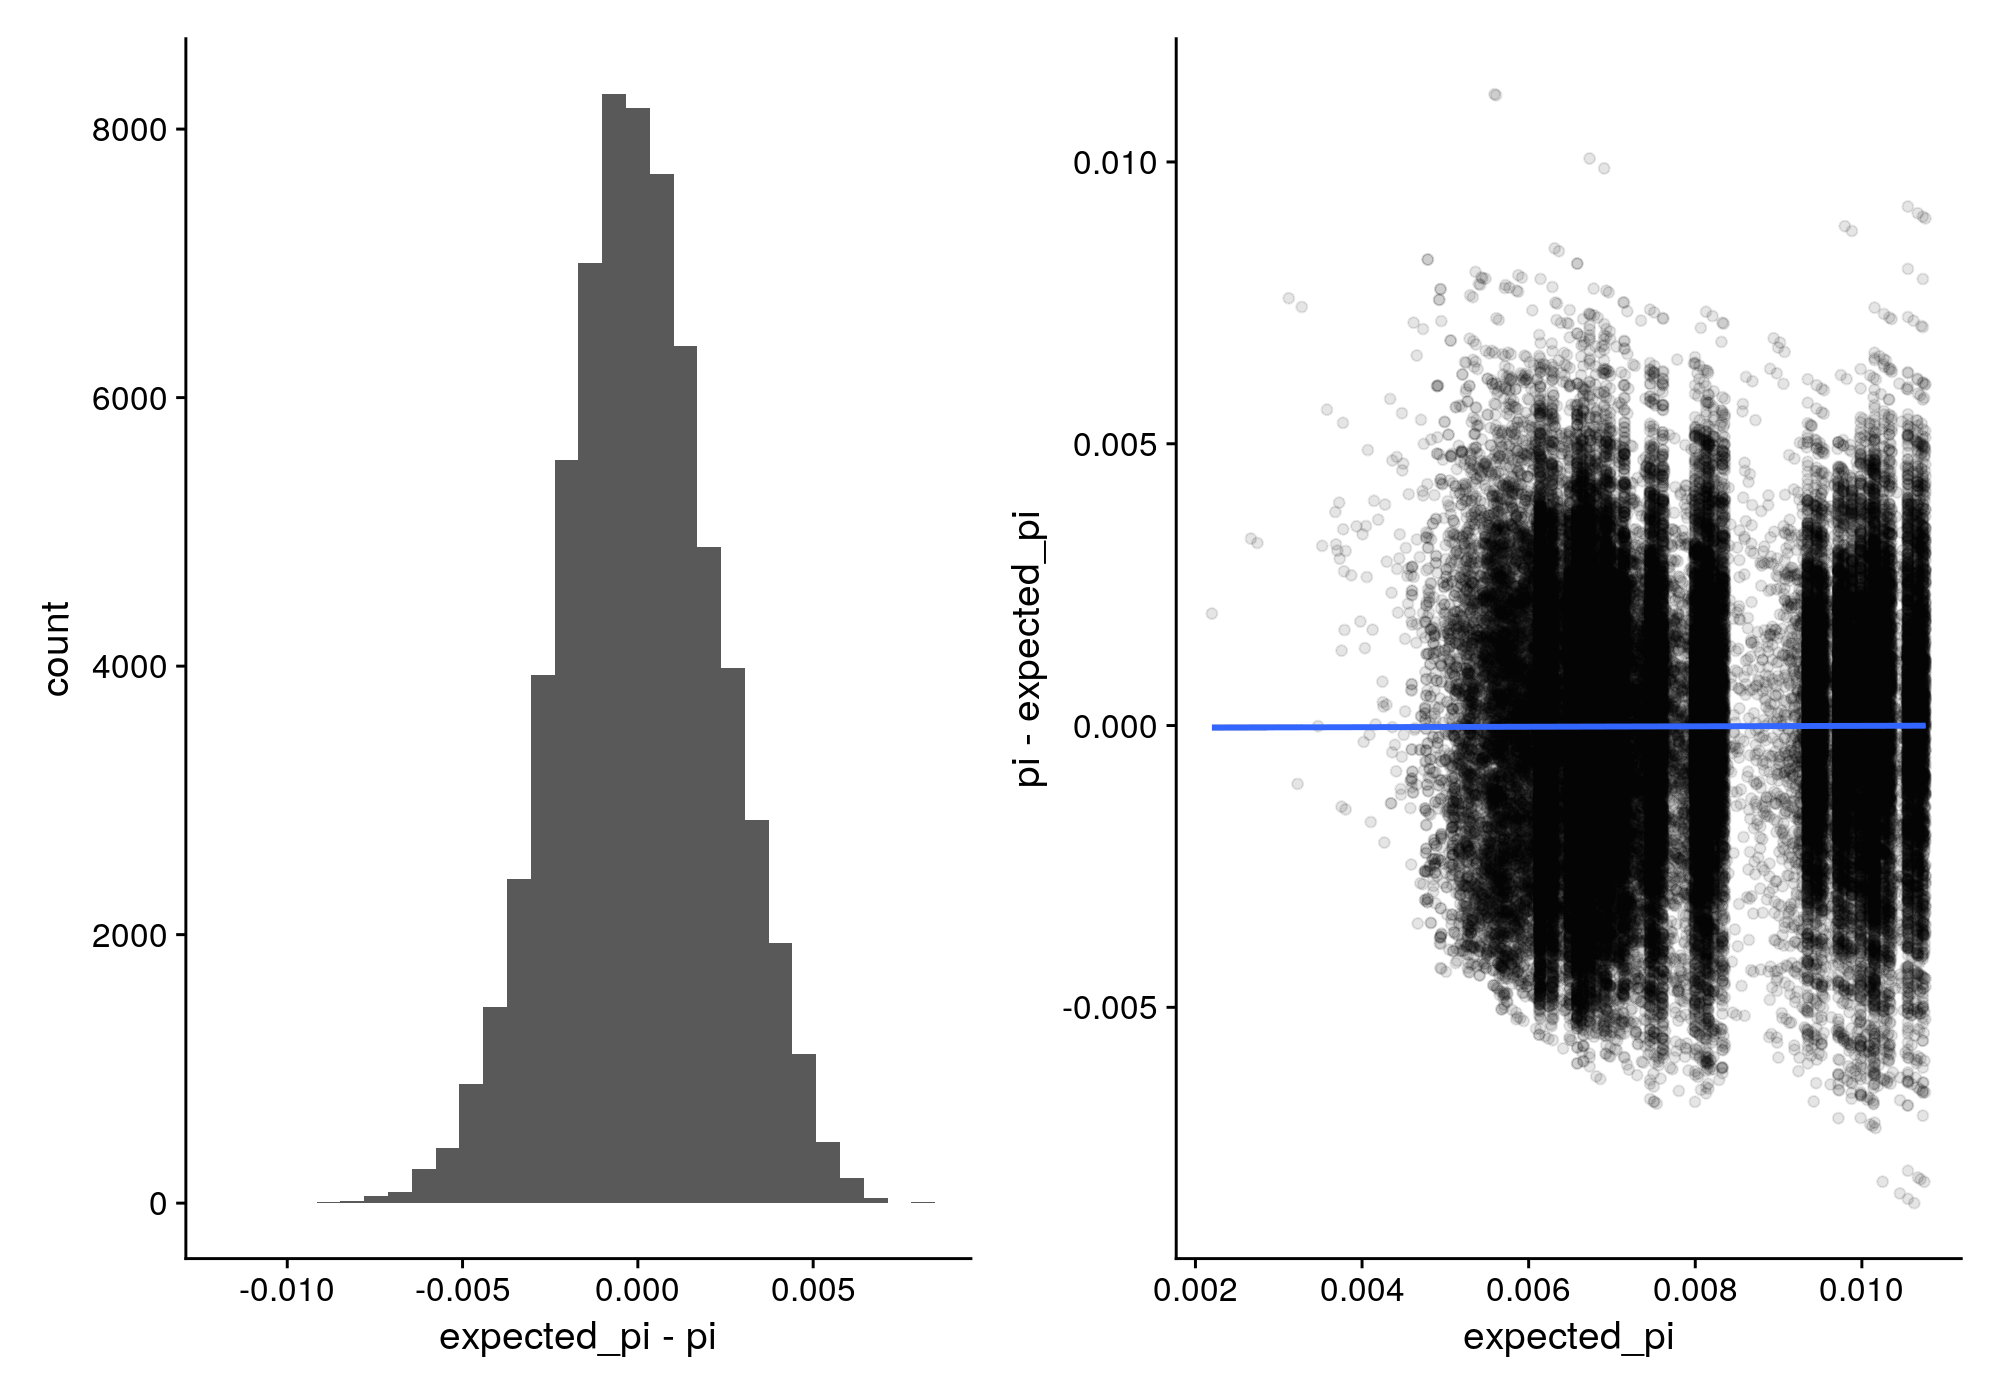

In [32]:
#histogram of residuals
hist_plot  <- 
  ggplot(pred_df, aes(expected_pi - pi)) +
    geom_histogram()

pred_resid_plot <- pred_df %>% 
mutate(rbp_i = -1*(100/2)*log(1 - 2*rbp_i)*1e6) %>% 
ggplot(aes(expected_pi,  pi - expected_pi)) +
geom_point(alpha = 0.1) +
geom_smooth(method = "lm")

hist_plot + pred_resid_plot

In [ ]:
%%bash
echo 'We can also use Bash magic. Try writing some Bash here'

In [ ]:
#JUST BETA on v4 for Mitra

library(GenomicRanges)
library(tidyverse)
library(Rcpp)

#!!!REQUIRES ALL INPUT DFS INCLUDE COLUMN NAMES chr, start, end

#Calculates G
cppFunction(
  'NumericVector get_G(double U, double sh, double P, NumericVector fd_i, NumericVector M_1, NumericVector M_2) {

  int n = M_1.size();
  double G_k;
  double M_i;
  NumericVector G_i(n);

  for(int i = 0; i < n; ++i) {
    M_i =  (M_1[i] + M_2[i]) / 2;
    for(int k = 0; k < n; ++k){
      G_k = U * fd_i[k] * sh / (2 * (sh + P*std::abs(M_i - M_1[k]))*(sh + P*std::abs(M_i - M_2[k])));
      G_i[i] += G_k;
    }
  }
  return G_i;
}'
)


CM <- function(genetic_df, pi_df){
  tibble(
  cm_start = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$start)$y,
  cm_end = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$end)$y,
  cm_mid = (cm_start + cm_end)/2,
  cm_mb = approx(x = genetic_df$pos, y = genetic_df$cm_mb, xout = (pi_df$start + pi_df$end)/2)$y,
  rec = cm_end - cm_start
  )
}


est_beta <- function(mu, s = 1e-4, h = 0.2, chrms, pi_df, genetic_map_df, functional_df, pop){
    
    Total_Exonic_Sites <- sum(functional_df$end - functional_df$start) 
    model_df <- chrms %>%  
    map_df(~{
        pi_winsize <- pi_df$end[1] - pi_df$start[1]
        gen_map_chr <- filter(genetic_map_df, chr == .x)
        pi_df_chr <- filter(pi_df, chr == .x)
        morgan_df <- CM(genetic_df = gen_map_chr, pi_df = pi_df_chr)
        gff_chr <- filter(functional_df, chr == .x)
                                      
        
        #get number of functional bases in each pi window using GenomicRanges
        pi_idx <- tibble(queryHits = seq_len(nrow(pi_df_chr)), widths = 0)
        gr1 <- GRanges(pi_df_chr$chr, IRanges(pi_df_chr$start, pi_df_chr$end))
        gr2 <- GRanges(gff_chr$chr, IRanges(gff_chr$start, gff_chr$end))
        hits <- findOverlaps(gr1, gr2)
        overlaps <- pintersect(gr1[queryHits(hits)], gr2[subjectHits(hits)])
        functional_bps_raw <- 
        data.frame(findOverlaps(gr1, gr2)) %>% 
        mutate(widths = width(overlaps)) %>% 
        full_join(., pi_idx, by = c("queryHits", "widths")) %>% 
        group_by(queryHits) %>%
        summarise(widths = sum(widths), .groups = 'drop') %>% 
        pull(widths)
        functional_bps <- functional_bps_raw/Total_Exonic_Sites 
        
        
        #Collect features, calculate G and Beta
        g_df <- bind_cols(tibble(functional_bps_raw = functional_bps_raw, functional_bps = functional_bps_raw/Total_Exonic_Sites), morgan_df, pi_df_chr) %>% drop_na()
        functional_bps <- g_df$functional_bps_raw/Total_Exonic_Sites
        G <- get_G(U = mu * Total_Exonic_Sites, sh = s * h, P = 1, fd_i = g_df$functional_bps,  M_1 = g_df$cm_start/100,  M_2 = g_df$cm_end/100)
        Beta = exp(-(mu*g_df$functional_bps_raw)/(g_df$cm_mb/1e4))
        mutate(g_df, G = G, Beta = Beta)
    }) 
}


ogut_path = "../../parv_local/shic/data/ogut_fifthcM_map_agpv4_INCLUDE.txt"
gen_map_all_chr <- read_delim(ogut_path, delim = "\t",
                             col_names = c("one", "two", "cm", "chr", "pos")) %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    bind_cols(df2, cm_mb)
  }) 

#made with 
#cat ../parv_local/adapt_mode/data/Zea_mays.B73_RefGen_v4.45.gff3  | grep "P001" | bedtools sort -i stdin | bedtools merge -i stdin > ~/v4_functional_bps.bed
gff_test <- vroom::vroom(
  "~/v4_functional_bps.bed", 
  delim = "\t",
  comment = "#", 
  col_names = c("chr", "start", "end")
  ) %>% 
drop_na()

chrms <- paste0(1:10)
PI = vroom::vroom("~/v4_steps.bed", "\t")
beta_df = est_beta(3e-8, chrms = chrms, pi_df = PI, genetic_map_df = gen_map_all_chr, functional_df = gff_test) #%>% drop_na()


In [ ]:
write_csv(beta_df, file = "~/v4_G_Beta.csv")


beta_df %>% 
    ggplot(aes((start+end)/2, G)) +
    geom_line() +
    facet_wrap(~chr) +
    cowplot::theme_cowplot()

beta_df %>% 
    ggplot(aes(cm_mb, Beta)) +
    geom_point() +
    cowplot::theme_cowplot()


In [ ]:
head(beta_df)

In [ ]:
#testing
PI  <-  read_angsd_pi(pi_files[1])
head(PI)
mu=3e-8; s = 1e-4; h = 0.2; chrms = chrms; pi_df = PI; genetic_map_df = gen_map_all_chr; functional_df = gff_test; pop = "test"
Total_Exonic_Sites <- sum(functional_df$end - functional_df$start)

poop <- model_df <- chrms %>%  
  map_df(~{
  .x <- "chr2"    
  pi_winsize <- pi_df$end[1] - pi_df$start[1]
  gen_map_chr <- filter(genetic_map_df, chr == .x)
  pi_df_chr <- filter(pi_df, chr == .x)
  morgan_df <- CM(genetic_df = gen_map_chr, pi_df = pi_df_chr)

  gff_chr <- filter(functional_df, chr == .x) %>% 
      distinct()
      
  #functional_bps_raw <- get_functional_bps(functional_df = gff_chr, pi_df = pi_df_chr) 
  #Exonic_Site_Locations = unique(c(gff_chr$start, gff_chr$end))
  #functional_bps_raw <- map_dbl(1:nrow(pi_df_chr), function(x) sum(Exonic_Site_Locations > pi_df_chr$start[x] & Exonic_Site_Locations < pi_df_chr$end[x]))
                                
  functional_bps_raw <- 
  map_dbl(1:nrow(pi_df_chr), function(x){
    htz <- gff_chr[gff_chr$start > pi_df_chr$start[x] & gff_chr$end < pi_df_chr$end[x], ]    
    sum(htz$end - htz$start)
  })

  functional_bps <- functional_bps_raw/Total_Exonic_Sites    
  g_df  <- bind_cols(tibble(functional_bps_raw = functional_bps_raw, functional_bps = functional_bps_raw/Total_Exonic_Sites), morgan_df, pi_df_chr) %>% drop_na()
  functional_bps <- g_df$functional_bps_raw/Total_Exonic_Sites
  G <- get_G(U = mu * Total_Exonic_Sites, sh = s * h, P = 1, fd_i = g_df$functional_bps,  M_1 = g_df$cm_start/100,  M_2 = g_df$cm_end/100)
  Beta = exp(-(mu*g_df$functional_bps_raw)/(g_df$cm_mb/1e4))                            
  rho = (1-exp(-1*(g_df$cm_mb/1e6)*2/100))/2

  mutate(g_df, G = G, Beta = Beta, rho = rho)
 })


poop      